<a href="https://colab.research.google.com/github/AugustoBonifacio001/AugustoBonifacio001/blob/main/notch_cosseno_fft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

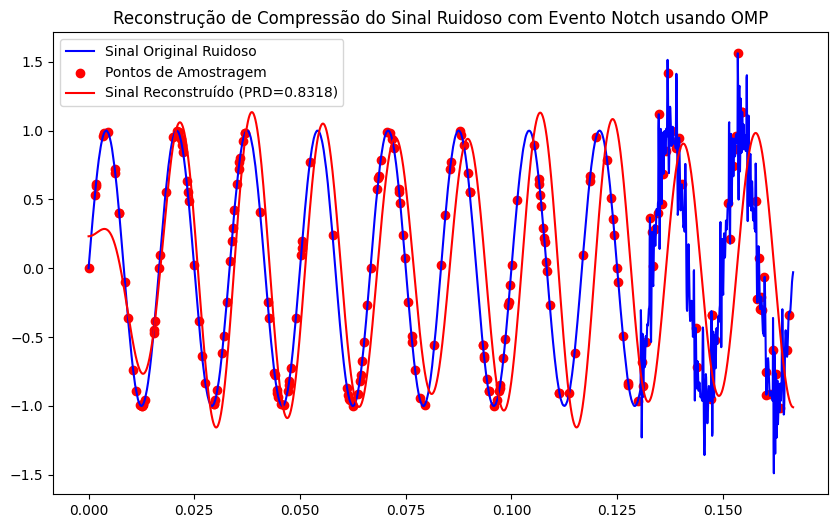

In [7]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import OrthogonalMatchingPursuit
import scipy.fftpack


def omp(Phi, u, s):
    omp_model = OrthogonalMatchingPursuit(n_nonzero_coefs=s)
    omp_model.fit(Phi, u)
    return omp_model.coef_

def calculate_prd(original, reconstructed):
  return np.sqrt(np.sum((original - reconstructed)**2)/np.sum((original)**2))

def evento_notch(SNRdb, n, T, Npc, Nc, FreqFund):
    AmpMin = 0.45
    Vm1 = 1
    fase = 0
    w0 = 2 * np.pi * FreqFund

    t = T * np.arange(0, n)
    x1 = Vm1 * np.sin(w0 * t + fase)

    a = np.random.uniform(1000, 2000)
    freq = np.random.uniform(1000, 3000)
    Npc_dist = np.random.randint(7 * Npc, 8 * Npc)
    n_dist = Npc_dist
    k = 0.7

    n2 = 0
    periodo = 32

    dist = np.zeros(n)
    for n1 in range(0, n):
        if n1 > Npc_dist:
            dist[n1] = k * np.exp(-a * t[n2]) * np.sin(2 * np.pi * freq * t[n2])
            n2 += 1
            if n1 == (Npc_dist + periodo) and (n1 < Nc * Npc - periodo):
                Npc_dist += periodo
                a = np.random.uniform(1000, 2000)
                freq = np.random.uniform(1000, 3000)
                n2 = 0
        if n1 <= Npc_dist:
            dist[n1] = 0

    Ps = (Vm1 ** 2) / 2
    Pr = Ps / (10 ** (SNRdb / 10))
    desvio = np.sqrt(Pr)
    R = np.random.normal(0, desvio, n)
    R -= np.mean(R)
    xIn = x1 + dist + R

    return xIn, n_dist, Nc, FreqFund

# Configurações
SNRdb = 60
Npc = 256
T = 1 / (Npc * 60)
Nc = 10
n = Nc * Npc
FreqFund = 60

# Geração do sinal com a introdução de ruído
xIn, _, _, _ = evento_notch(SNRdb, n, T, Npc, Nc, FreqFund)

# Amostragem aleatória do sinal ruidoso
p = 220
amostras_aleatorias = np.round((len(xIn)) * np.random.rand(p)).astype(int)
y = xIn[amostras_aleatorias]

# Aqui {y} = [C]{x} = [C][Phi]{s}, onde Phi é a transformada discreta do cosseno inversa

Phi = scipy.fftpack.dct(np.eye(n), axis=0, norm='ortho')
CPhi = Phi[amostras_aleatorias,:]
#Phi = np.fft.fft(np.eye(n, n)) * 1
#CPhi = np.imag(Phi[amostras_aleatorias, :])

# OMP para minimização de l1
s_reconstruido = omp(CPhi, y, 10)  # obter o vetor esparso através do algoritmo OMP
x_rec = np.dot(Phi.T, s_reconstruido)
#x_rec = np.imag(np.fft.fft(s_reconstruido))
# Calcular o MSE
prd_omp = calculate_prd(xIn, x_rec[:len(xIn)])

# Visualizar o sinal original ruidoso com pontos de amostragem aleatória e erro
plt.figure(figsize=(10, 6))
t = T * np.arange(0, len(xIn))
plt.plot(t, xIn, 'b', label='Sinal Original Ruidoso')
plt.scatter(np.arange(0, T * n, T)[amostras_aleatorias], xIn[amostras_aleatorias], color='red', label='Pontos de Amostragem')
plt.plot(t, x_rec[:len(xIn)], 'r', label=f'Sinal Reconstruído (PRD={prd_omp:.4f})')
plt.title('Reconstrução de Compressão do Sinal Ruidoso com Evento Notch usando OMP')
plt.legend()
plt.show()

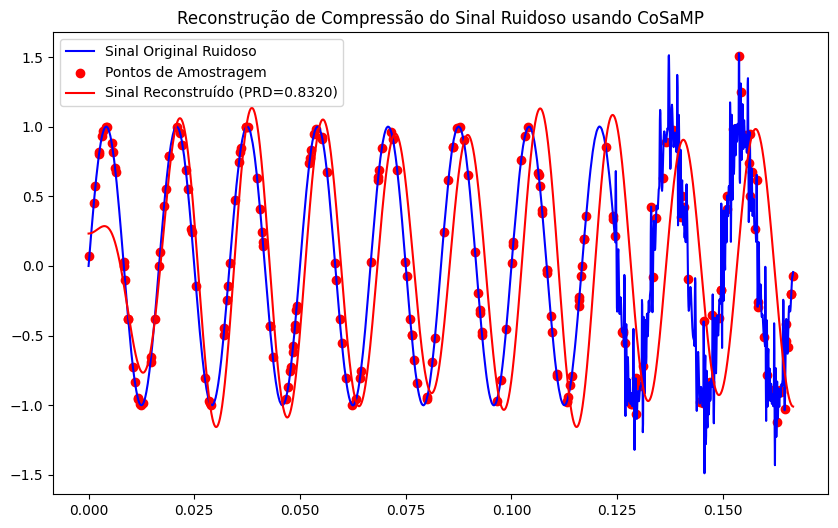

In [10]:
from scipy.linalg import pinv
from scipy.fft import fft

def cosamp(Phi, u, s, tol=1e-10, max_iter=50):
    max_iter -= 1
    num_precision = 1e-12
    a = np.zeros(Phi.shape[1])
    v = u
    iter = 0
    halt = False
    while not halt:
        iter += 1
        y = np.abs(np.dot(Phi.T, v))
        Omega = [i for (i, val) in enumerate(y) if val > np.sort(y)[::-1][2 * s] and val > num_precision]
        T = np.union1d(Omega, a.nonzero()[0])
        b = np.dot(pinv(Phi[:, T]), u)
        igood = (np.abs(b) > np.sort(np.abs(b))[::-1][s]) & (np.abs(b) > num_precision)
        T = T[igood]
        a[T] = b[igood]
        v = u - np.dot(Phi[:, T], b[igood])

        halt = np.linalg.norm(v) / np.linalg.norm(u) < tol or iter > max_iter

    return a

def calculate_prd(original, reconstructed):
   return np.sqrt(np.sum((original - reconstructed)**2)/np.sum((original)**2))

def evento_notch(SNRdb, n, T, Npc, Nc, FreqFund):
    AmpMin = 0.45
    Vm1 = 1
    fase = 0
    w0 = 2 * np.pi * FreqFund

    t = T * np.arange(0, n)
    x1 = Vm1 * np.sin(w0 * t + fase)

    a = np.random.uniform(1000, 2000)
    freq = np.random.uniform(1000, 3000)
    Npc_dist = np.random.randint(7 * Npc, 8 * Npc)
    n_dist = Npc_dist
    k = 0.7

    n2 = 0
    periodo = 32

    dist = np.zeros(n)
    for n1 in range(0, n):
        if n1 > Npc_dist:
            dist[n1] = k * np.exp(-a * t[n2]) * np.sin(2 * np.pi * freq * t[n2])
            n2 += 1
            if n1 == (Npc_dist + periodo) and (n1 < Nc * Npc - periodo):
                Npc_dist += periodo
                a = np.random.uniform(1000, 2000)
                freq = np.random.uniform(1000, 3000)
                n2 = 0
        if n1 <= Npc_dist:
            dist[n1] = 0

    Ps = (Vm1 ** 2) / 2
    Pr = Ps / (10 ** (SNRdb / 10))
    desvio = np.sqrt(Pr)
    R = np.random.normal(0, desvio, n)
    R -= np.mean(R)
    xIn = np.zeros_like(x1)
    xIn = x1[:len(xIn)]
    xIn += dist[:len(xIn)]
    xIn += R[:len(xIn)]

    return xIn, n_dist, Nc, FreqFund

# Configurações
SNRdb = 60
Npc = 256
T = 1 / (Npc * 60)
Nc = 10
n = Nc * Npc
FreqFund = 60

# Geração do sinal com a introdução de ruído
xIn, _, _, _ = evento_notch(SNRdb, n, T, Npc, Nc, FreqFund)

# Restante do código...

# Adiciona o mesmo ruído usado na função evento_notch
noisy_signal = np.zeros(len(xIn))
noisy_signal[:len(xIn)] = xIn

# Amostragem aleatória do sinal ruidoso
p = 220
amostras_aleatorias = np.round((len(xIn)) * np.random.rand(p)).astype(int)
y = noisy_signal[amostras_aleatorias]

# Aqui {y} = [C]{x} = [C][Phi]{s}, onde Phi é a transformada discreta do cosseno inversa
Phi = scipy.fftpack.dct(np.eye(n), axis=0, norm='ortho')
CPhi = Phi[amostras_aleatorias,:]
#Phi = np.fft.fft(np.eye(n, n))
#CPhi = np.imag(Phi[amostras_aleatorias, :])


# CoSaMP para minimização de l1:

s_reconstruido_cosamp = cosamp(CPhi, y, 10)  # obter o vetor esparso através do algoritmo CoSaMP

x_rec = np.dot(Phi.T, s_reconstruido)
#x_rec = np.imag(np.fft.fft(s_reconstruido))

# Calcular o prd:
prd_cosamp = calculate_prd(noisy_signal, x_rec[:len(xIn)])

# Visualizar o sinal original ruidoso com pontos de amostragem aleatória e erro
plt.figure(figsize=(10, 6))
t = T * np.arange(0, len(xIn))
plt.plot(t, noisy_signal, 'b', label='Sinal Original Ruidoso')
plt.scatter(np.arange(0, T * n, T)[amostras_aleatorias], noisy_signal[amostras_aleatorias], color='red', label='Pontos de Amostragem')
plt.plot(t, x_rec[:len(xIn)], 'r', label=f'Sinal Reconstruído (PRD={prd_cosamp:.4f})')
plt.title('Reconstrução de Compressão do Sinal Ruidoso usando CoSaMP')
plt.legend()
plt.show()
